<a href="https://colab.research.google.com/github/markwreinke/OrganStopClassifier/blob/main/AudioClassificationMedium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a tutorial taken from https://medium.com/@hasithsura/audio-classification-d37a82d6715 

Be sure to look at the github, as the article doesn't have the whole code: https://github.com/hasithsura/Environmental-Sound-Classification/blob/master/ESC50-Pytorch.ipynb


In [1]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os

In [2]:
# Mounting google drive into colab, and ensuring we are in the data folder
from google.colab import drive
drive.mount("/content/drive")

dir = "/content/drive/My Drive/ESC-50-master"
print(os.getcwd())

if(os.getcwd() != dir):
  os.chdir(dir)

print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/My Drive/ESC-50-master


In [3]:
# Here we are reading a comma separated values (CSV) file using pandas into the 
# variable df. df is type a 2D data structure with labeled axes, 
# as a DataFrame or TextParser
df = pd.read_csv('meta/esc50.csv')

In [4]:
# Return the first n rows of the DataFrame. n defaults to 5 with no args
df.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

In [5]:
# The data was sorted into 5 "Cross-validation" folds, in which here, the first
# four are used as training data, and the fifth is a validation set
# Here's the paper: http://karol.piczak.com/papers/Piczak2015-ESC-Dataset.pdf
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [6]:
# Load a filewith librosa, and display its sampling rate and length
wav, sr = librosa.load('audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [7]:
# Here we are going to convert a Spectrogram into an image
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

  # This spectrogram is normalized using z score normalization and 
  # scaled using min-max scaling so its values lie between 0 and 255

In [8]:
# This function give a mel spectrogram of the given file
#  sr=None -> Librosa should use the native sampling rate of 44.1KHz to load the audio data instead of the default of 22.05KHz
#  Next the first 5 seconds of given audio is extracted
#  2048 samples are chosen for each window (about 46ms)
#  A hop_length of 512 samples is chose, meaning the window is moved by skipping 512 samples to get the next time frame
#  The number of mel filters is 128, makes the height of the spectrogram image 128
#  fmin and fmax are the lowest and highest frequencies
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav, sr = librosa.load(file_path, sr=sr)
  if wav.shape[0]<5*sr:
     wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]

  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)

  #Librosa squares the magnitude of the spectrogram when constructing Mel Spectrogram, so we use power_to_db to convert power magnitude to decipels. top_db is used to threshold the output.
  spec_db=librosa.power_to_db(spec, top_db=top_db)
  return spec_db

In [9]:
# This is us loading data into pytorch by building dataloaders to
# preprocess and load data.

class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i = {}
    self.i2c = {}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category] = i
      self.i2c[i] = category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base, row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])

  def __len__(self):
     return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

train_data = ESC50Data('audio', train, 'filename', 'category')
valid_data = ESC50Data('audio', valid, 'filename', 'category')
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = 16, shuffle = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [11]:
# This is its own model, not the resnet34
class ESC50Model(nn.Module):
  def __init__(self, input_shape, batch_size=16, num_cats=50):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(500, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2) 
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x

In [12]:
# Build a model using a pre-trained model, resnet34
from torchvision.models import resnet34
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device = torch.device('cpu')

resnet_model = resnet34(pretrained = True)
resnet_model.fc = nn.Linear(512, 50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size = (7,7), stride=(2,2), padding = (3, 3), bias = False)
resnet_model = resnet_model.to(device)

# The first conv1 layer of resnet34 accepts 3 channels so it is changed to accept 1 channel.
# The final fc layer generates output for 1000 categoris so it is changed to 50 categories




Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [14]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

  return optimizer

In [15]:
# Train the model
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr = learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer

def train(model, loss_fn, train_loser, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr = None):
  for epoch in tqdm(range(1,epochs+1)):
     model.train()
     batch_losses=[]
     if change_lr:
       optimizer = change_lr(optimizer, epoch)
     for i, data in enumerate(train_loader):
       x,y = data
       optimizer.zero_grad()
       x = x.to(device, dtype = torch.float32)
       y = y.to(device, dtype = torch.long)
       y_hat = model(x)
       loss = loss_fn(y_hat, y)
       loss.backward()
       batch_losses.append(loss.item())
       optimizer.step()
     train_losses.append(batch_losses)
     print(f'Epoch = {epoch} Train-Loss : {np.mean(train_losses[-1])}')
     model.eval()
     batch_losses=[]
     trace_y = []
     trace_yhat = []

     for i, data in enumerate(valid_loader):
       x,y = data
       x = x.to(device, dtype=torch.float32)
       y = y.to(device, dtype = torch.long)
       y_hat = model(x)
       loss = loss_fn(y_hat, y)
       trace_y.append(y.cpu().detach().numpy())
       trace_yhat.append(y_hat.cpu().detach().numpy())
       batch_losses.append(loss.item())

     valid_losses.append(batch_losses)
     trace_y = np.concatenate(trace_y)
     trace_yhat = np.concatenate(trace_yhat)
     accuracy = np.mean(trace_yhat.argmax(axis = 1) == trace_y)
     print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Epoch = 1 Train-Loss : 2.480826994776726
Epoch - 1 Valid-Loss : 1.683825469017029 Valid-Accuracy : 0.5125
Epoch = 2 Train-Loss : 1.207503177523613
Epoch - 2 Valid-Loss : 1.5658824634552002 Valid-Accuracy : 0.575
Epoch = 3 Train-Loss : 0.6810350301861763
Epoch - 3 Valid-Loss : 1.7127731847763061 Valid-Accuracy : 0.5575
Epoch = 4 Train-Loss : 0.49931936532258986
Epoch - 4 Valid-Loss : 1.383225281238556 Valid-Accuracy : 0.6125
Epoch = 5 Train-Loss : 0.3299290546774864
Epoch - 5 Valid-Loss : 1.272160186767578 Valid-Accuracy : 0.67
Epoch = 6 Train-Loss : 0.3152787259221077
Epoch - 6 Valid-Loss : 1.3549692904949189 Valid-Accuracy : 0.64
Epoch = 7 Train-Loss : 0.21136065427213907
Epoch - 7 Valid-Loss : 1.1086100542545319 Valid-Accuracy : 0.695
Epoch = 8 Train-Loss : 0.16363393370062113
Epoch - 8 Valid-Loss : 1.0383339715003967 Valid-Accuracy : 0.73
Epoch = 9 Train-Loss : 0.14283291916362942
Epoch - 9 Valid-Loss : 1.5140347790718078 Valid-Accuracy : 0.5825
Changed learning rate to 2e-05
Epoch 

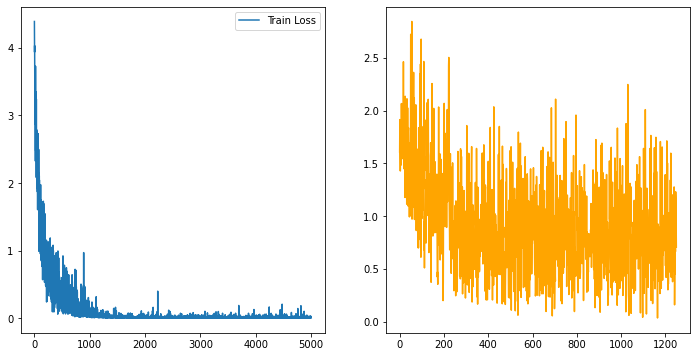

In [16]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')

In [18]:
# Here we will save the model
with open('esc50resnet.pth', 'wb') as f:
  torch.save(resnet_model, f)

In [21]:
# This appears to save the traindata dataloader as a file
import pickle
with open('indtocat.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)

{0: 'airplane', 1: 'breathing', 2: 'brushing_teeth', 3: 'can_opening', 4: 'car_horn', 5: 'cat', 6: 'chainsaw', 7: 'chirping_birds', 8: 'church_bells', 9: 'clapping', 10: 'clock_alarm', 11: 'clock_tick', 12: 'coughing', 13: 'cow', 14: 'crackling_fire', 15: 'crickets', 16: 'crow', 17: 'crying_baby', 18: 'dog', 19: 'door_wood_creaks', 20: 'door_wood_knock', 21: 'drinking_sipping', 22: 'engine', 23: 'fireworks', 24: 'footsteps', 25: 'frog', 26: 'glass_breaking', 27: 'hand_saw', 28: 'helicopter', 29: 'hen', 30: 'insects', 31: 'keyboard_typing', 32: 'laughing', 33: 'mouse_click', 34: 'pig', 35: 'pouring_water', 36: 'rain', 37: 'rooster', 38: 'sea_waves', 39: 'sheep', 40: 'siren', 41: 'sneezing', 42: 'snoring', 43: 'thunderstorm', 44: 'toilet_flush', 45: 'train', 46: 'vacuum_cleaner', 47: 'washing_machine', 48: 'water_drops', 49: 'wind'}
tensor([[-0.7589, -2.4363, -4.0871, -5.4443, -2.8847, -3.1824, 12.7886, -2.2391,
         -2.7226, -3.0149, -2.8282, -3.7386, -2.9437,  2.6655, -3.0525, -2.6

<class 'torchvision.models.resnet.ResNet'>


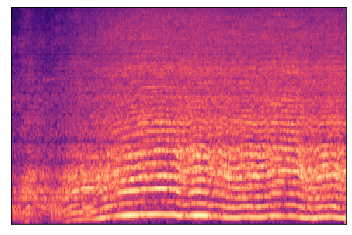

In [38]:
# Calls a file and puts it through the resnet model in order to classify it

# Opens the traindata dataloader file
import IPython
with open('indtocat.pkl','rb') as f:
  indtocat = pickle.load(f)
print(indtocat) # This will list all of the categories

# Save the filepath of an audio file
filename='/content/drive/My Drive/ESC-50-master/audio/1-116765-A-41.wav'

# create a mel spectrogram image
spec = spec_to_image(get_melspectrogram_db(filename))
librosa.display.specshow(spec) # display spec

spec_t = torch.tensor(spec).to(device, dtype=torch.float32) #spec_t is spec as a tensor, to the current device

# pr is a tensor listing the probabilities that the input tensor belongs in of each category
pr = resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape)) 
print(pr)

# tensor.argmax returns the indices of the maximum value of all elements in the input tensor
# Essentially, here we want to find the max value == the index of the category inwhich the input of pr most likely belongs to
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0] 
print(ind) # Print the index
print(indtocat[ind]) # Print the category label

IPython.display.display(IPython.display.Audio(filename=filename)) # This will show a player that plays the file. (might only work in google colab?)


In [31]:
# Here we find a sound from the soundbible website, and run it through the network to try to identify it

!wget 'http://soundbible.com/grab.php?id=2215&type=wav' -O "dog.wav"
filename='dog.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

--2020-11-21 23:54:11--  http://soundbible.com/grab.php?id=2215&type=wav
Resolving soundbible.com (soundbible.com)... 169.47.128.197
Connecting to soundbible.com (soundbible.com)|169.47.128.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘dog.wav’

dog.wav                 [   <=>              ]   3.61M  6.05MB/s    in 0.6s    

2020-11-21 23:54:12 (6.05 MB/s) - ‘dog.wav’ saved [3786304]

dog


In [40]:
# Same as above, but this time, a cat meow

!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
filename='cat.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

--2020-11-22 00:14:09--  http://soundbible.com/grab.php?id=1954&type=wav
Resolving soundbible.com (soundbible.com)... 169.47.128.197
Connecting to soundbible.com (soundbible.com)|169.47.128.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘cat.wav’

cat.wav                 [  <=>               ] 873.05K  2.51MB/s    in 0.3s    

2020-11-22 00:14:10 (2.51 MB/s) - ‘cat.wav’ saved [894000]

cat
